In [4]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from matplotlib.colors import ListedColormap
import pickle


## Exploracion de los datos

In [5]:
df = pd.read_csv(r'..\data\bgg_dataset.csv', sep=';')

In [6]:
df.head(10)

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,174430.0,Gloomhaven,2017.0,1,4,120,14,42055,"8,79",1,"3,86",68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936.0,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,"8,61",2,"2,84",65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"
2,224517.0,Brass: Birmingham,2018.0,2,4,120,14,19217,"8,66",3,"3,91",28785.0,"Hand Management, Income, Loans, Market, Networ...",Strategy Games
3,167791.0,Terraforming Mars,2016.0,1,5,120,12,64864,"8,43",4,"3,24",87099.0,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games
4,233078.0,Twilight Imperium: Fourth Edition,2017.0,3,6,480,14,13468,"8,70",5,"4,22",16831.0,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games"
5,291457.0,Gloomhaven: Jaws of the Lion,2020.0,1,4,120,14,8392,"8,87",6,"3,55",21609.0,"Action Queue, Campaign / Battle Card Driven, C...","Strategy Games, Thematic Games"
6,182028.0,Through the Ages: A New Story of Civilization,2015.0,2,4,120,14,23061,"8,43",7,"4,41",26985.0,"Action Points, Auction/Bidding, Auction: Dutch...",Strategy Games
7,220308.0,Gaia Project,2017.0,1,4,150,12,16352,"8,49",8,"4,35",20312.0,"End Game Bonuses, Hexagon Grid, Income, Modula...",Strategy Games
8,187645.0,Star Wars: Rebellion,2016.0,2,4,240,14,23081,"8,42",9,"3,71",34849.0,"Area Majority / Influence, Area Movement, Area...",Thematic Games
9,12333.0,Twilight Struggle,2005.0,2,2,180,13,40814,"8,29",10,"3,59",56219.0,"Action/Event, Advantage Token, Area Majority /...","Strategy Games, Wargames"


Analizamos las columnas:

ID: identificador único para cada juego de mesa en el DataFrame.

Name: nombre del juego de mesa.

Year Published: año en que se publicó el juego.

Min Players: número mínimo de jugadores necesarios para poder jugar el juego.

Max Players: número máximo de jugadores que pueden participar en el juego.

Play Time: duración promedio de una partida del juego.

Min Age: edad mínima recomendada para jugar el juego.

Users Rated: número de usuarios que han calificado el juego en la plataforma de juegos de mesa BoardGameGeek.

Rating Average: promedio de las calificaciones de los usuarios del juego en BoardGameGeek, en una escala de 1 a 10.

BGG Rank: clasificación del juego según los usuarios de BoardGameGeek, basada en las calificaciones y el número de personas que han calificado el juego.

Complexity Average: promedio de la complejidad del juego según los usuarios de BoardGameGeek, en una escala de 1 a 5.

Owned Users: número de usuarios que poseen una copia del juego en BoardGameGeek.

Mechanics: mecánicas de juego que se utilizan en el juego. Luego las exploraremos.

Domains: géneros a los que pertenece el juego.


### Vamos a ver ciertas curiosidades




In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20343 entries, 0 to 20342
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  20327 non-null  float64
 1   Name                20343 non-null  object 
 2   Year Published      20342 non-null  float64
 3   Min Players         20343 non-null  int64  
 4   Max Players         20343 non-null  int64  
 5   Play Time           20343 non-null  int64  
 6   Min Age             20343 non-null  int64  
 7   Users Rated         20343 non-null  int64  
 8   Rating Average      20343 non-null  object 
 9   BGG Rank            20343 non-null  int64  
 10  Complexity Average  20343 non-null  object 
 11  Owned Users         20320 non-null  float64
 12  Mechanics           18745 non-null  object 
 13  Domains             10184 non-null  object 
dtypes: float64(3), int64(6), object(5)
memory usage: 2.2+ MB


Vamos a cambiar el Rating y Complexity ya que son floats y estan como object

In [8]:
df['Complexity Average']=df['Complexity Average'].apply(lambda x: x.replace(',','.')) # Cambiamos las , por puntos
df['Complexity Average']=df['Complexity Average'].apply(lambda x: float(x)) # Convertimos a float
df['Rating Average']=df['Rating Average'].apply(lambda x: x.replace(',','.')) # Cambiamos las , por puntos
df['Rating Average']=df['Rating Average'].apply(lambda x: float(x)) # Convertimos a float

In [9]:
df.describe()

,ID,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users
count,20327.000000,20342.000000,20343.000000,20343.000000,20343.000000,20343.000000,20343.000000,20343.000000,20343.000000,20343.000000,20320.000000
mean,108216.245142,1984.249877,2.019712,5.672221,91.294548,9.601485,840.971391,6.403227,10172.890429,1.991188,1408.457628
std,98682.097298,214.003181,0.690366,15.231376,545.447203,3.645458,3511.562220,0.935911,5872.831597,0.848903,5040.179315
min,1.000000,-3500.000000,0.000000,0.000000,0.000000,0.000000,30.000000,1.050000,1.000000,0.000000,0.000000
25%,11029.000000,2001.000000,2.000000,4.000000,30.000000,8.000000,55.000000,5.820000,5087.500000,1.330000,146.000000
50%,88931.000000,2011.000000,2.000000,4.000000,45.000000,10.000000,120.000000,6.430000,10173.000000,1.970000,309.000000
75%,192939.500000,2016.000000,2.000000,6.000000,90.000000,12.000000,385.000000,7.030000,15258.500000,2.540000,864.000000
max,331787.000000,2022.000000,10.000000,999.000000,60000.000000,25.000000,102214.000000,9.580000,20344.000000,5.000000,155312.000000


Vamos aver por que el minimo de año publicado es -3500, estarán mal los datos?

In [10]:
df_sort = df.sort_values('Year Published')
df_sort.head(10)

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
8174,2399.0,Senet,-3500.0,2,2,30,6,664,5.82,8176,1.48,1343.0,"Dice Rolling, Roll / Spin and Move",Abstract Games
1275,2397.0,Backgammon,-3000.0,2,2,30,8,11680,6.54,1276,2.02,17747.0,"Advantage Token, Betting and Bluffing, Dice Ro...",Abstract Games
20219,5546.0,Marbles,-3000.0,1,0,10,4,473,4.69,20221,1.10,399.0,Flicking,Children's Games
8924,1602.0,The Royal Game of Ur,-2600.0,2,2,30,10,549,5.90,8926,1.31,1162.0,"Dice Rolling, Roll / Spin and Move, Square Gri...",Abstract Games
172,188.0,Go,-2200.0,2,2,180,8,14843,7.64,173,4.00,20398.0,"Enclosure, Square Grid",Abstract Games
19648,19915.0,Three Men's Morris,-1400.0,2,2,5,5,60,4.31,19650,1.25,60.0,"Pattern Building, Point to Point Movement",Abstract Games
20002,3886.0,Nine Men's Morris,-1400.0,2,2,20,6,1310,5.36,20004,1.84,1642.0,"Pattern Building, Point to Point Movement",Abstract Games
20342,11901.0,Tic-Tac-Toe,-1300.0,2,2,1,4,3275,2.68,20344,1.16,1374.0,"Paper-and-Pencil, Pattern Building","Abstract Games, Children's Games"
20341,5432.0,Chutes and Ladders,-200.0,2,6,30,3,3783,2.86,20343,1.02,4400.0,"Dice Rolling, Grid Movement, Race, Roll / Spin...",Children's Games
15134,21488.0,Petteia,-100.0,2,2,20,5,51,6.01,15136,2.17,93.0,"Action Queue, Area Majority / Influence",Abstract Games


¡Qué interesante! Senet es un juego del antiguo Egipto, The Royal Game of Ur de Mesopotamia, Go de China, Chutes and Ladders	de la India y Petteia de Grecia.

También podemos observar que hay un juego con una duración un poco alta 60.000 minutos, vamos aver que sucede.

In [11]:
df_sort = df.sort_values('Play Time')
df_sort.tail(10)

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
8449,13182.0,Korsun Pocket: Little Stalingrad on the Dnepr,1979.0,2,6,6000,12,50,7.80,8451,4.54,178.0,"Dice Rolling, Grid Movement, Hexagon Grid, Mov...",Wargames
5195,209511.0,Atlanta Is Ours,2018.0,1,2,7920,0,105,8.71,5197,3.86,566.0,"Dice Rolling, Grid Movement, Hexagon Grid, Mov...",Wargames
6518,236650.0,1985: Under an Iron Sky,2018.0,2,6,8640,16,90,9.12,6520,4.27,363.0,"Dice Rolling, Hexagon Grid, Simulation, Zone o...",Wargames
13607,239982.0,The Enigma Box,2017.0,1,4,10000,12,65,6.92,13609,3.86,171.0,"Cooperative Game, Memory, Paper-and-Pencil, St...",NaN
9497,6942.0,Drang Nach Osten!,1973.0,2,4,12000,12,77,6.82,9499,4.22,192.0,"Dice Rolling, Hexagon Grid, Simulation",Wargames
1322,254.0,Empires in Arms,1983.0,2,7,12000,14,1238,7.60,1323,4.42,2129.0,"Area Movement, Dice Rolling, Movement Points, ...",Wargames
7895,158793.0,Atlantic Wall: D-Day to Falaise,2014.0,2,6,14400,16,69,8.08,7897,4.89,328.0,"Hexagon Grid, Zone of Control",Wargames
6035,46669.0,1914: Offensive à outrance,2013.0,2,4,17280,0,108,7.98,6037,4.07,661.0,"Dice Rolling, Hexagon Grid, Simulation",Wargames
3208,29285.0,Case Blue,2007.0,2,2,22500,12,289,8.26,3210,4.58,711.0,"Dice Rolling, Hexagon Grid, Simulation",Wargames
13420,4815.0,The Campaign for North Africa: The Desert War ...,1979.0,8,10,60000,14,146,6.10,13422,4.71,385.0,"Dice Rolling, Hexagon Grid, Simulation",Wargames


Tenemos al rey de la corona, The Campaign for North Africa catalogado como el juego más largo del mundo se dice que si te juntas con tus amigos a jugar 3 horas dos veces al mes

tardarías 20 años en acabar una partida.

In [12]:
df_sort = df.sort_values('Users Rated')
df_sort[['Name','Users Rated','Owned Users']].tail(10)

,Name,Users Rated,Owned Users
27,Puerto Rico,63128,73413.0
30,Agricola,63498,75679.0
3,Terraforming Mars,64864,87099.0
92,Codenames,67688,107682.0
173,Ticket to Ride,71611,97463.0
97,Dominion,78089,101839.0
60,7 Wonders,84371,112410.0
394,Catan,101510,154531.0
177,Carcassonne,101853,149337.0
98,Pandemic,102214,155312.0


Como podemos observar no es de extrañar que los juegos más votados sean también los que más gente tiene. Prácticamente todos los que tenemos aquí son mundialmente 

conocidos y ganadores de premios, pero los primeros 3 se nos van totalmente de la media, consideraremos quitarlos.

Vamos a ver el top 5 de los mejores valorados por la comunidad.

In [13]:
df_sort = df.sort_values('Rating Average')
df_sort.tail(5)

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
16310,228370.0,TerroriXico,2017.0,2,4,30,10,70,9.43,16312,2.50,35.0,"Area Majority / Influence, Cooperative Game, D...",NaN
13547,281257.0,Aeolis,2020.0,1,7,120,18,37,9.43,13549,2.00,15.0,"Area Majority / Influence, Campaign / Battle C...",NaN
10246,275972.0,Star Trek: Alliance - Dominion War Campaign,2021.0,1,2,30,14,54,9.46,10248,3.29,117.0,Cooperative Game,NaN
11687,322354.0,DEFCON 1,2021.0,2,5,180,14,57,9.54,11689,3.00,12.0,Variable Player Powers,NaN
14596,275777.0,Erune,0.0,2,5,120,12,31,9.58,14598,0.00,10.0,"Action Points, Dice Rolling, Modular Board, Pa...",NaN


Como podemos ver rápidamente, es lógico que tengan altas valoraciones cuando son tan pocos usuarios los que han votado y los que lo poseen. Erune es un juego de kick starter que esta teniendo muy buena recepción por la comunidad.

## Visualizaciones

LLegó el momento de mostrar graficas!

Lo primero será un pairplot para poder identificar outliers facilmente.

In [14]:
#sns.pairplot(df)

Como podemos ver nos salen aquellos que hemos valorado previamente en el describe, los 3 favoritos, los antiguos el interminable y unos cuantos con jugadores indeterminados.

Visualizemos mas detallado

#### Graficas curiosas

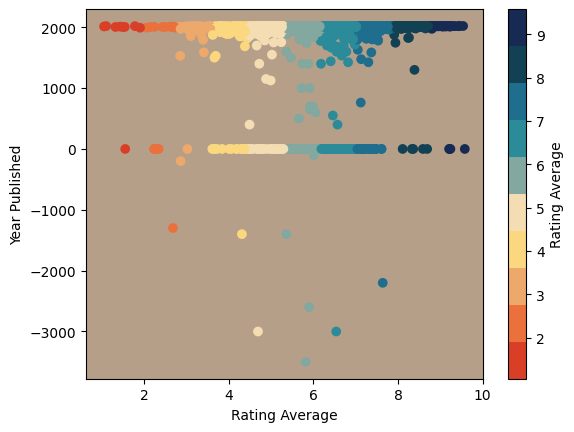

In [15]:

limits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
colors = ['#d93f27','#ea713c','#eda96c','#fbd87f', '#f4ddb3', '#83a89f', '#2b8b99', '#1f6e8d',  '#124154','#172a53']
cmap = ListedColormap(colors)

rating_average = df['Rating Average']
year_published = df['Year Published']

fig, ax = plt.subplots()
ax.set_facecolor('#B59F89')
scatter = ax.scatter(rating_average, year_published, c=rating_average, cmap=cmap)
cbar = plt.colorbar(scatter)
cbar.set_label('Rating Average')
plt.xlabel('Rating Average')
plt.ylabel('Year Published');

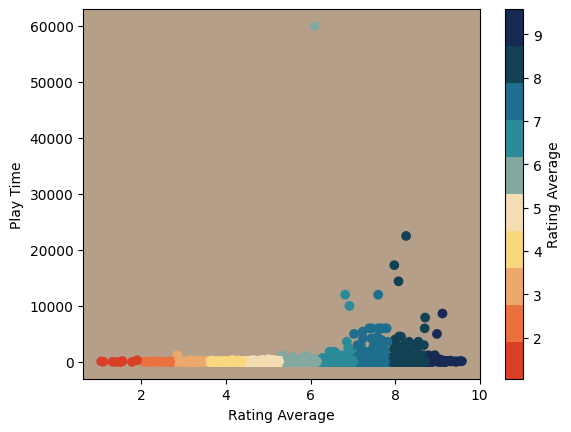

In [16]:
rating_average = df['Rating Average']
play_time = df['Play Time']
fig, ax = plt.subplots()
ax.set_facecolor('#B59F89')
scatter = ax.scatter(rating_average, play_time, c=rating_average, cmap=cmap)
cbar = plt.colorbar(scatter)
cbar.set_label('Rating Average')
plt.xlabel('Rating Average')
plt.ylabel('Play Time');

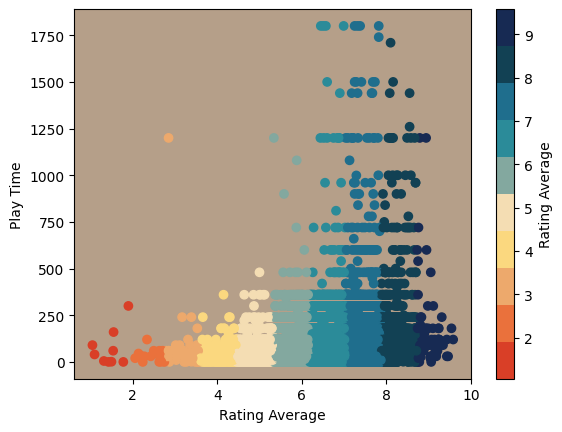

In [17]:
filtered_df = df[df['Play Time'] < 2000]
rating_average = filtered_df['Rating Average']
play_time = filtered_df['Play Time']
fig, ax = plt.subplots()
ax.set_facecolor('#B59F89')
scatter = ax.scatter(rating_average, play_time, c=rating_average, cmap=cmap)
cbar = plt.colorbar(scatter)
cbar.set_label('Rating Average')
plt.xlabel('Rating Average')
plt.ylabel('Play Time');

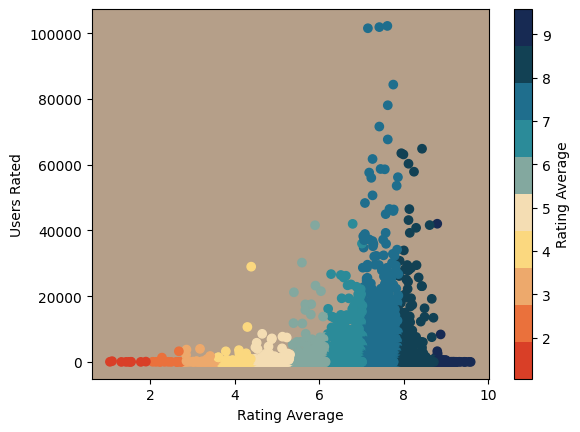

In [18]:
rating_average = df['Rating Average']
users_rated = df['Users Rated']
fig, ax = plt.subplots()
ax.set_facecolor('#B59F89')
scatter = ax.scatter(rating_average, users_rated, c=rating_average, cmap=cmap)
cbar = plt.colorbar(scatter)
cbar.set_label('Rating Average')
plt.xlabel('Rating Average')
plt.ylabel('Users Rated');

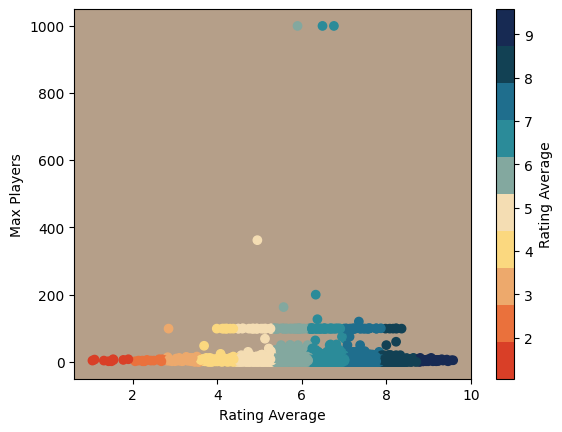

In [19]:
filtered_df = df[df['Max Players'] < 1000]
rating_average = filtered_df['Rating Average']
max_players= filtered_df['Max Players']
fig, ax = plt.subplots()
ax.set_facecolor('#B59F89')
scatter = ax.scatter(rating_average, max_players, c=rating_average, cmap=cmap)
cbar = plt.colorbar(scatter)
cbar.set_label('Rating Average')
plt.xlabel('Rating Average')
plt.ylabel('Max Players');

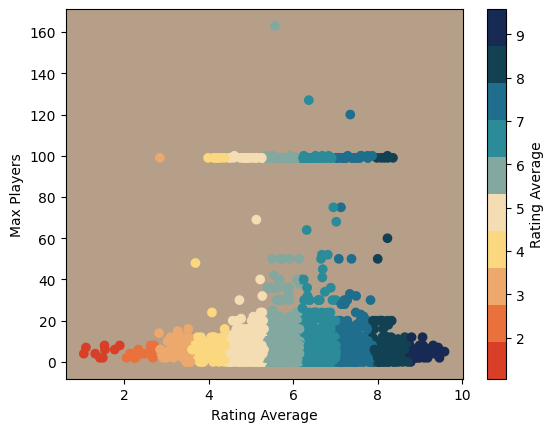

In [20]:
filtered_df = df[df['Max Players'] < 200]
rating_average = filtered_df['Rating Average']
max_players= filtered_df['Max Players']
fig, ax = plt.subplots()
ax.set_facecolor('#B59F89')
scatter = ax.scatter(rating_average, max_players, c=rating_average, cmap=cmap)
cbar = plt.colorbar(scatter)
cbar.set_label('Rating Average')
plt.xlabel('Rating Average')
plt.ylabel('Max Players');

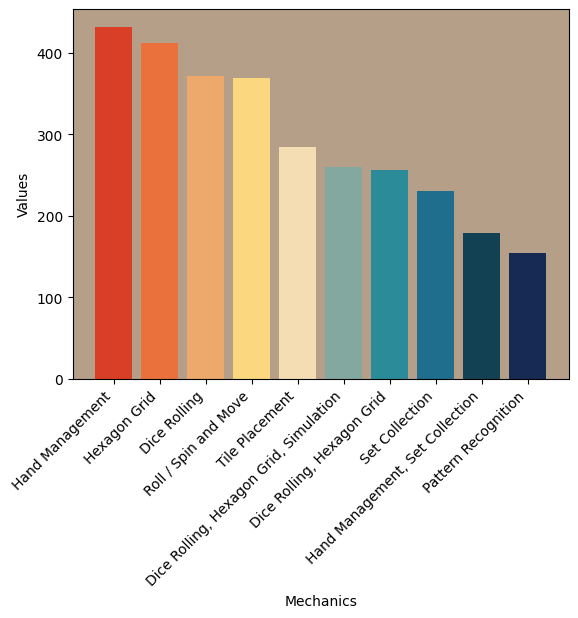

In [21]:
mechanics= df['Mechanics'].value_counts()
fig, ax = plt.subplots()
ax.set_facecolor('#B59F89')
scatter = ax.bar(mechanics.index[:10], mechanics.values[:10],color=colors)
plt.xlabel('Mechanics')
plt.ylabel('Values')
plt.xticks(rotation=45, ha='right', fontsize=10);

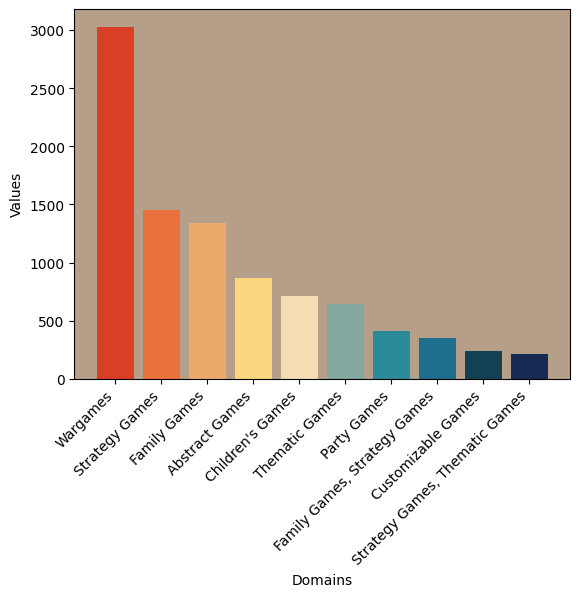

In [22]:
domains= df['Domains'].value_counts()
fig, ax = plt.subplots()
ax.set_facecolor('#B59F89')
scatter = ax.bar(domains.index[:10], domains.values[:10],color=colors)
plt.xlabel('Domains')
plt.ylabel('Values')
plt.xticks(rotation=45, ha='right', fontsize=10);

## Limpiamos los datos

Vamos a eliminar estos Outliers molestos


In [23]:
df2 = df[(df["Max Players"]<200)]
df2 = df[(df["Play Time"]<30000)]
df2 = df[(df["Min Age"]<22)]
df2 = df[(df["Users Rated"]<100000)]
df2 = df[(df["Year Published"]>-1000)]

Ahora toca lidiar con los valores nulos

In [24]:
# Comprobamos los valores nulos
df2.isnull().sum()

ID                       15
Name                      0
Year Published            0
Min Players               0
Max Players               0
Play Time                 0
Min Age                   0
Users Rated               0
Rating Average            0
BGG Rank                  0
Complexity Average        0
Owned Users              22
Mechanics              1597
Domains               10158
dtype: int64

Tenemos muchos valores nulos en Domain y mechanics, vamos a valorar si liquidarlos o rellenarlos.

In [25]:
df2.Domains.unique()

array(['Strategy Games, Thematic Games', 'Strategy Games',
       'Thematic Games', 'Strategy Games, Wargames',
       'Thematic Games, Wargames', 'Family Games, Strategy Games',
       'Customizable Games, Thematic Games',
       'Abstract Games, Family Games', 'Customizable Games',
       'Family Games', 'Party Games', 'Customizable Games, Wargames',
       'Wargames', 'Party Games, Thematic Games', 'Abstract Games',
       'Customizable Games, Strategy Games',
       'Family Games, Thematic Games', 'Family Games, Party Games',
       'Abstract Games, Strategy Games', "Children's Games, Family Games",
       nan, 'Party Games, Strategy Games', "Children's Games",
       "Children's Games, Party Games",
       'Abstract Games, Customizable Games',
       'Family Games, Strategy Games, Thematic Games',
       'Family Games, Party Games, Thematic Games',
       'Strategy Games, Thematic Games, Wargames',
       'Abstract Games, Party Games', "Abstract Games, Children's Games",
       'F

Por lo pronto vemos muchos generos repetidos, vamos a limpiar todo esto, separandolos y eliminando la palabra "games" que se repite constantemente.

In [27]:
# Modificamos la columna domains para poder dividirla
df2['Domains']=df2['Domains'].apply(str) #Convertimos en string
df2['Domains']=df2['Domains'].apply(lambda x: ' '.join(x.lower() for x in x.split())) # Las volvemos minusculas
df2['Domains']=df2['Domains'].apply(lambda x: x.replace('[^\w\s]', '')) # Cambiamos cualquier carácter que no sea una letra, un número o un espacio en blanco
df2['Domains']=df2['Domains'].replace('[\d]','') # Eliminamos digitos
df2['Domains']=df2['Domains'].apply(lambda x: x.replace(',', '')) # Eliminamos las ,
df2['Domains']=df2['Domains'].apply(lambda x: x.replace('games', '')) # Eliminamos la palabra games

C:\Users\Yeray\AppData\Local\Temp\ipykernel_18380\58493560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Domains']=df2['Domains'].apply(str) #Convertimos en string
C:\Users\Yeray\AppData\Local\Temp\ipykernel_18380\58493560.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Domains']=df2['Domains'].apply(lambda x: ' '.join(x.lower() for x in x.split())) # Las volvemos minusculas
C:\Users\Yeray\AppData\Local\Temp\ipykernel_18380\58493560.py:4: SettingWithCopyWarning: 
A value is trying to be 

In [28]:
df2.Domains.unique()

array(['strategy  thematic ', 'strategy ', 'thematic ', 'strategy  war',
       'thematic  war', 'family  strategy ', 'customizable  thematic ',
       'abstract  family ', 'customizable ', 'family ', 'party ',
       'customizable  war', 'war', 'party  thematic ', 'abstract ',
       'customizable  strategy ', 'family  thematic ', 'family  party ',
       'abstract  strategy ', "children's  family ", 'nan',
       'party  strategy ', "children's ", "children's  party ",
       'abstract  customizable ', 'family  strategy  thematic ',
       'family  party  thematic ', 'strategy  thematic  war',
       'abstract  party ', "abstract  children's ", 'family  war',
       'family  thematic  war', 'abstract  war',
       "children's  family  party ", 'party  war', "children's  war",
       'customizable  thematic  war', "abstract  children's  war",
       'abstract  strategy  thematic ', 'abstract  thematic '],
      dtype=object)

Mucho mejor, pero que hacemos con los nans?

In [29]:
df2[df2['Domains'].isna()]

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains


Son muy dispares, y tenemos muchos, los dejaremos sin genero al no pertenecer a ningun grupo ya que no los podemos eliminar

In [30]:

def categoric_encoder(x):
    lista=np.zeros(len(df2)) # Creamos una lista de zeros igual de larga que el df
    for i in range (len(lista)):
        if i in df2[df2['Domains'].str.contains(x)].index: # Comprobamos si la fila contiene la palabra, en caso positivo le damos valor de 1 
            lista[i]=1
        else:
            lista[i]=0
    return lista

In [31]:
# Creamos columnas nuevas con la funcion, en caso de que la fila contenenga la palabra se le atribuira el valor de 1
df2['Strategy']=categoric_encoder('strategy')
df2['Thematic']=categoric_encoder('thematic')
df2['Children']=categoric_encoder("children's")
df2['Party']=categoric_encoder("party")
df2['Abstract']=categoric_encoder("abstract")
df2['War']=categoric_encoder("war")
df2['Family']=categoric_encoder("family")
df2['Customizable']=categoric_encoder("customizable")

C:\Users\Yeray\AppData\Local\Temp\ipykernel_18380\2123987957.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Strategy']=categoric_encoder('strategy')
C:\Users\Yeray\AppData\Local\Temp\ipykernel_18380\2123987957.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Thematic']=categoric_encoder('thematic')
C:\Users\Yeray\AppData\Local\Temp\ipykernel_18380\2123987957.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Vamos a mirar ahora Mechanics

In [35]:
df2

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,...,Mechanics,Domains,Strategy,Thematic,Children,Party,Abstract,War,Family,Customizable
0,174430.0,Gloomhaven,2017.0,1,4,120,14,42055,8.79,1,...,"Action Queue, Action Retrieval, Campaign / Bat...",strategy thematic,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,161936.0,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,8.61,2,...,"Action Points, Cooperative Game, Hand Manageme...",strategy thematic,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,224517.0,Brass: Birmingham,2018.0,2,4,120,14,19217,8.66,3,...,"Hand Management, Income, Loans, Market, Networ...",strategy,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,167791.0,Terraforming Mars,2016.0,1,5,120,12,64864,8.43,4,...,"Card Drafting, Drafting, End Game Bonuses, Han...",strategy,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,233078.0,Twilight Imperium: Fourth Edition,2017.0,3,6,480,14,13468,8.70,5,...,"Action Drafting, Area Majority / Influence, Ar...",strategy thematic,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20337,1410.0,Trouble,1965.0,2,4,45,4,3255,3.79,20339,...,Roll / Spin and Move,children's,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
20338,16398.0,War,0.0,2,2,30,4,1340,2.28,20340,...,NaN,children's,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
20339,7316.0,Bingo,1530.0,2,99,60,5,2154,2.85,20341,...,"Betting and Bluffing, Bingo, Pattern Recognition",party,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
20340,5048.0,Candy Land,1949.0,2,4,30,3,4006,3.18,20342,...,Roll / Spin and Move,children's,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [32]:
len(df2.Mechanics.unique())

7379

Esto es una locura no pueden existir tantos metodos de juego, vamos a profundizar más.

In [33]:
df2.Mechanics.unique()

array(['Action Queue, Action Retrieval, Campaign / Battle Card Driven, Card Play Conflict Resolution, Communication Limits, Cooperative Game, Deck Construction, Deck Bag and Pool Building, Grid Movement, Hand Management, Hexagon Grid, Legacy Game, Modular Board, Once-Per-Game Abilities, Scenario / Mission / Campaign Game, Simultaneous Action Selection, Solo / Solitaire Game, Storytelling, Variable Player Powers',
       'Action Points, Cooperative Game, Hand Management, Legacy Game, Point to Point Movement, Set Collection, Trading, Variable Player Powers',
       'Hand Management, Income, Loans, Market, Network and Route Building, Score-and-Reset Game, Tech Trees / Tech Tracks, Turn Order: Stat-Based, Variable Set-up',
       ...,
       'Auction/Bidding, Income, Loans, Lose a Turn, Player Elimination, Roll / Spin and Move, Set Collection, Stock Holding, Track Movement, Trading',
       'Betting and Bluffing, Bingo, Pattern Recognition',
       'Dice Rolling, Grid Movement, Race, Roll 

In [34]:
df2['Mechanics']

0        Action Queue, Action Retrieval, Campaign / Bat...
1        Action Points, Cooperative Game, Hand Manageme...
2        Hand Management, Income, Loans, Market, Networ...
3        Card Drafting, Drafting, End Game Bonuses, Han...
4        Action Drafting, Area Majority / Influence, Ar...
                               ...                        
20337                                 Roll / Spin and Move
20338                                                  NaN
20339     Betting and Bluffing, Bingo, Pattern Recognition
20340                                 Roll / Spin and Move
20341    Dice Rolling, Grid Movement, Race, Roll / Spin...
Name: Mechanics, Length: 20334, dtype: object

Tomaremos la decisión de eliminarla ya que son muy diferentes.

In [36]:
# Eliminamos las columnas que consideramos no útiles
df2 = df2.drop(['ID','Name','Mechanics','Domains'],axis=1)


In [52]:
df2.dropna(inplace=True)

In [53]:
X=df2.drop('Rating Average',axis=1)
y=df2['Rating Average']

## Empezamos a modelar

In [55]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)

In [56]:
lr=LinearRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
print("Score del modelo (R^2):", lr.score(X_train, y_train))
print('MSE for LR Model: ',mean_squared_error(y_test,y_pred) )
print("R^2 score:", r2_score(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))

Score del modelo (R^2): 0.6163097936418375
MSE for LR Model:  0.3655664639695722
R^2 score: 0.5887586554999863
MAE: 0.43383948364633157


In [57]:
knn=KNeighborsRegressor()
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
print("Score del modelo (R^2):", knn.score(X_train, y_train))
print('MSE for KNN Model: ',mean_squared_error(y_test,y_pred) )
print("R^2 score:", r2_score(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))

Score del modelo (R^2): 0.9217675026096837
MSE for KNN Model:  0.11400558566364712
R^2 score: 0.8717502425694823
MAE: 0.20504174871996853


In [59]:
xgb_reg = XGBRegressor()
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 200]
}

grid_search_xgb = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 200]})

In [60]:
xgb_reg = XGBRegressor(**grid_search_xgb.best_params_)

xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)
print("Score del modelo (R^2):", xgb_reg.score(X_train, y_train))
print('MSE for XGB Model: ',mean_squared_error(y_test,y_pred) )
print("R^2 score:", r2_score(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))

Score del modelo (R^2): 0.9722584964934499
MSE for XGB Model:  0.048202540279998846
R^2 score: 0.9457749016203173
MAE: 0.12415160494838563


In [61]:
rf_reg = RandomForestRegressor()
param_grid = {
    "n_estimators": [100,120,280,200],
    "max_depth": [3,4,5,6,10,15,17],
    "max_features": ["sqrt", 3, 4]
}

grid_search_rf = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 10, 15, 17],
                         'max_features': ['sqrt', 3, 4],
                         'n_estimators': [100, 120, 280, 200]})

In [62]:
rf_reg = RandomForestRegressor(**grid_search_rf.best_params_)

rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)
print("Score del modelo (R^2):", rf_reg.score(X_train, y_train))
print('MSE for RF Model: ',mean_squared_error(y_test,y_pred) )
print("R^2 score:", r2_score(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))

Score del modelo (R^2): 0.9753740062881188
MSE for RF Model:  0.10209809849565002
R^2 score: 0.885145483969392
MAE: 0.20516599184309217


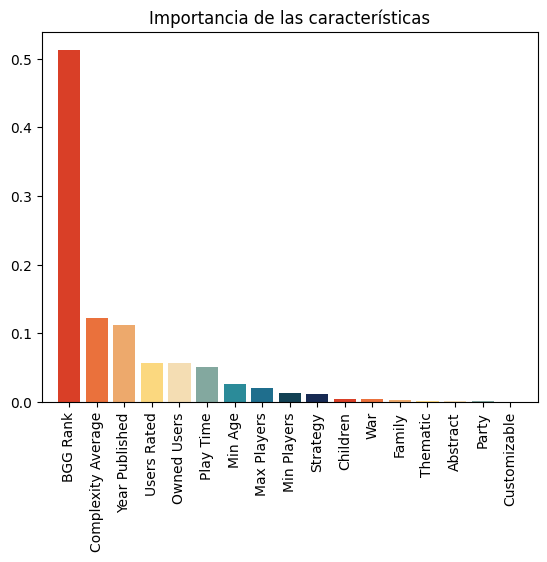

In [63]:
importances = rf_reg.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Importancia de las características")
plt.bar(range(X.shape[1]), importances[indices],
        color=colors, align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [64]:
#Probamos escalando los datos
std_scale = StandardScaler().fit(X_train)
X_train_scal = std_scale.transform(X_train)
X_test_scal = std_scale.transform(X_test)

In [65]:
rf_reg = RandomForestRegressor(**grid_search_rf.best_params_)

rf_reg.fit(X_train_scal, y_train)
y_pred = rf_reg.predict(X_test_scal)
print("Score del modelo (R^2):", rf_reg.score(X_train_scal, y_train))
print('MSE for RF Model: ',mean_squared_error(y_test,y_pred) )
print("R^2 score:", r2_score(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))

Score del modelo (R^2): 0.9754644620984002
MSE for RF Model:  0.10123552636671185
R^2 score: 0.8861158282350582
MAE: 0.20378085038756627


In [66]:
xgb_reg = XGBRegressor(**grid_search_xgb.best_params_)

xgb_reg.fit(X_train_scal, y_train)
y_pred = xgb_reg.predict(X_test_scal)
print("Score del modelo (R^2):", xgb_reg.score(X_train_scal, y_train))
print('MSE for XGB Model: ',mean_squared_error(y_test,y_pred) )
print("R^2 score:", r2_score(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))

Score del modelo (R^2): 0.9722584964934499
MSE for XGB Model:  0.04815500463092955
R^2 score: 0.9458283765042622
MAE: 0.12411603906014718


# Conclusión

Datos curiosos:

* Tenemos muchos juegos antiguos el más antiguo es de -3500, senet de Egipto seguido por backgammon, The Royal Game of Ur de Mesopotamia y Go de China
* The Campaign for North Africa catalogado como el juego más largo del mundo.
* El juego mejor votado es Erune, nacido de kickstarter.
* Hay casi 200 mecanicas diferentes, desde dados a subastas de diferentes tipos.

Si queremos lanzar un juego popular y bien recibido debe tener estas caracteristicas:

* 4-5 jugadores
* Duración de 90 minutos
* Que no sea muy complicado
* Estilo Wargame

El mejor modelo es un XGBRegressor con un MAE de 0.12 y un r2 score de 0.97